<a href="https://colab.research.google.com/github/Amisha1019/Image-Colorization-and-Generative-AI/blob/main/Copy_of_Task_4_of_colorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
marcinrutecki_old_photos_path = kagglehub.dataset_download('marcinrutecki/old-photos')

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        def down(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),
                nn.ReLU(True),
                nn.Conv2d(out_c, out_c, 3, padding=1),
                nn.ReLU(True),
                nn.MaxPool2d(2)
            )

        def up(in_c, out_c):
            return nn.Sequential(
                nn.ConvTranspose2d(in_c, out_c, 2, stride=2),
                nn.ReLU(True),
                nn.Conv2d(out_c, out_c, 3, padding=1),
                nn.ReLU(True)
            )

        self.down1 = down(1, 64)
        self.down2 = down(64, 128)
        self.down3 = down(128, 256)

        self.bottleneck = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1),
            nn.ReLU(True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(True)
        )

        self.up3 = up(512, 256)
        self.up2 = up(256, 128)
        self.up1 = up(128, 64)

        self.final = nn.Conv2d(64, 3, 1)

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)

        bottleneck = self.bottleneck(d3)

        u3 = self.up3(bottleneck)
        u2 = self.up2(u3)
        u1 = self.up1(u2)

        out = torch.sigmoid(self.final(u1))
        return out

In [ ]:
class ColorizationDataset(Dataset):
    def __init__(self, folder):
        self.images = [folder + "/" + f for f in os.listdir(folder)
                       if f.lower().endswith((".jpg", ".png", ".jpeg"))]

        self.augment = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(20),
            transforms.ColorJitter(brightness=0.3, contrast=0.3),
            transforms.Resize((256, 256))
        ])

        self.to_tensor = transforms.ToTensor()
        self.gray = transforms.Grayscale()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = Image.open(self.images[idx]).convert("RGB")
        img_aug = self.augment(img)

        gray = self.gray(img_aug)
        gray = self.to_tensor(gray)
        color = self.to_tensor(img_aug)

        return gray, color

In [ ]:
DATASET_PATH = "/kaggle/input/old-photos"


In [ ]:
DATASET_PATH = "/kaggle/input/old-photos"

dataset = ColorizationDataset(DATASET_PATH)
loader = DataLoader(dataset, batch_size=4, shuffle=True)

print("Total training images:", len(dataset))

Total training images: 29


In [ ]:
model = UNet().to(device)
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [ ]:
EPOCHS = 5  # increase if GPU allows

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for gray, color in loader:
        gray, color = gray.to(device), color.to(device)

        optimizer.zero_grad()
        pred = model(gray)
        loss = criterion(pred, color)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {total_loss/len(loader):.4f}")

torch.save(model.state_dict(), "/kaggle/working/colorization_augmented.pth")
print("Model saved to /kaggle/working/colorization_augmented.pth")




Epoch 1/5 - Loss: 0.2609
Epoch 2/5 - Loss: 0.2447
Epoch 3/5 - Loss: 0.2402
Epoch 4/5 - Loss: 0.2614
Epoch 5/5 - Loss: 0.2441
Model saved to /kaggle/working/colorization_augmented.pth


In [ ]:
def show_result(gray, pred, real):
    gray = gray.squeeze().cpu().numpy()
    pred = pred.squeeze().permute(1,2,0).detach().cpu().numpy()
    real = real.squeeze().permute(1,2,0).cpu().numpy()

    plt.figure(figsize=(12,4))

    plt.subplot(1,3,1)
    plt.title("Grayscale Input")
    plt.imshow(gray, cmap="gray")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.title("Colorized Output")
    plt.imshow(pred)
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.title("Ground Truth")
    plt.imshow(real)
    plt.axis("off")

    plt.show()


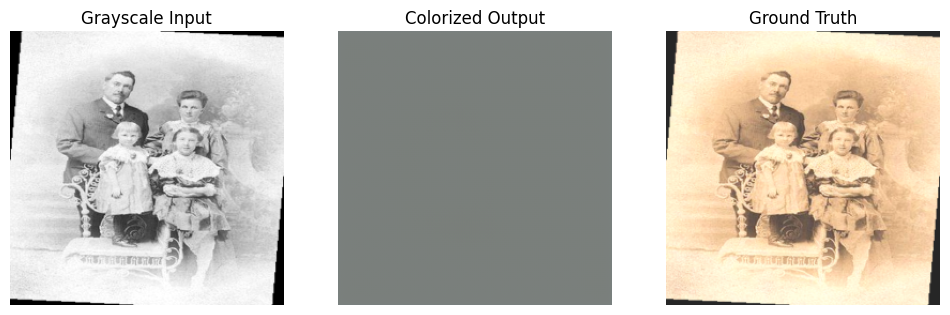

In [ ]:
gray, real = dataset[0]
gray_batch = gray.unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    pred = model(gray_batch)

show_result(gray, pred[0], real)
